In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import igraph as ig
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from node2vec import Node2Vec

#### Stochastic block model generation

In [2]:
np.random.seed(42)

In [3]:
k = 10; nk = 50
n = k * nk
z = np.repeat(range(k), nk)

B = np.zeros((k,k))
p1 = 0.02; p2 = 0.05

for i in range(k):
    B[i,i] = p1
    B[i,(i+1)%k] = p2; B[(i+1)%k,i] = p2

In [4]:
dB, UB = np.linalg.eig(B)
print(np.round(dB,3))
print('Signature p =', len(np.where(dB > 0)[0]), 'q =', len(np.where(dB < 0)[0]))

[-0.08  -0.061 -0.011  0.051  0.12   0.101 -0.061 -0.011  0.101  0.051]
Signature p = 5 q = 5


In [5]:
colours = [plt.cm.rainbow(zi/(k-1)) for zi in z] 

In [6]:
A = np.zeros((n,n))
for i in range(n):
    for j in range(i+1,n):
        edge = stats.bernoulli.rvs(B[z[i],z[j]])
        A[i,j] = edge; A[j,i] = edge

In [7]:
G = ig.Graph.Adjacency(A.tolist(), mode=ig.ADJ_UNDIRECTED)
ig.summary(G)

IGRAPH U--- 500 1458 -- 


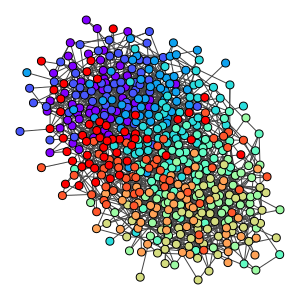

In [8]:
layout = G.layout("lgl")

visual_style = {}
visual_style["vertex_size"] = 8
visual_style["vertex_color"] = colours
visual_style["layout"] = layout
visual_style["bbox"] = (300, 300)
ig.plot(G, **visual_style)

#### Spectral embedding of adjacency matrix

In [9]:
dA, UA = np.linalg.eig(A)
XA = np.real_if_close(UA[:,0:k].dot(np.diag(np.sqrt(np.abs(dA[0:k])))))

Use PCA to embed the adjacency spectral embedding into two dimensions. This dimensionality reduction technique has the advantage that we know that the communities should form approximate Gaussian clusters due to the GRDPG central limit theorem and because PCA is linear dimensionality reduction.

In [10]:
pca = PCA(n_components=2)
XApca = pca.fit_transform(XA)

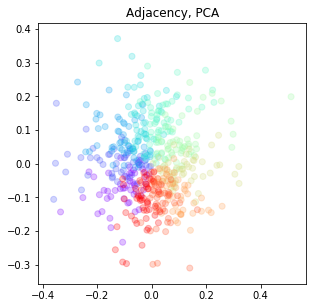

In [11]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Adjacency, PCA')
ax.scatter(XApca[:,0], XApca[:,1], c=colours, alpha=0.25);

Use t-SNE to embed the adjacency spectral embedding into two dimensions.

In [12]:
tsne = TSNE(n_components=2)
XAtsne = tsne.fit_transform(XA)

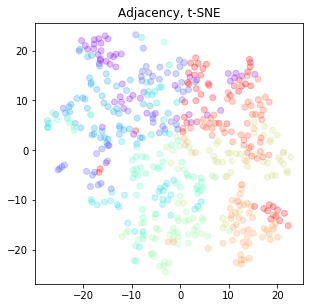

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Adjacency, t-SNE')
ax.scatter(XAtsne[:,0], XAtsne[:,1], c=colours, alpha=0.25);

#### Spectral embedding of the modularity matrix

This is just an opportunity to test the usefulness of using the modularity matrix, defined as $M = A - \frac{d d^\top}{2m}$, where $d$ is the degrees vector and $m$ is the number of edges. There are some strong links of the normalised modularity matrix to the Laplacian embedding.

In [28]:
M = A - np.outer(np.sum(A,axis=0),np.sum(A,axis=0))/np.sum(A)

Since the maximum degree for this graph is 15 and the number of edges is 1458, the entries in $M$ are at most different to the corresponding entry in $A$ is around 0.08 so not very big. For much larger graphs, this will be even less significant which may be a good reason not to worry too much about this embedding.

In [30]:
dM, UM = np.linalg.eig(M)
XM = UM[:,0:k].dot(np.diag(np.sqrt(np.abs(dM[0:k]))))

Use PCA to embed the modularity spectral embedding into two dimensions. This appears to be very similar to the adjacency spectral embedding.

In [32]:
XMpca = pca.fit_transform(XM)

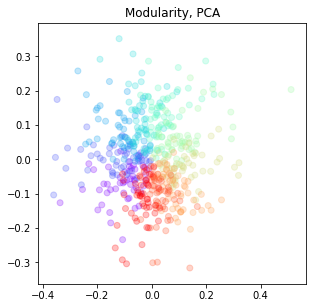

In [33]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Modularity, PCA')
ax.scatter(XMpca[:,0], XMpca[:,1], c=colours, alpha=0.25);

Use t-SNE to embed the modularity spectral embedding into two dimensions.

In [38]:
XMtsne = tsne.fit_transform(XM)

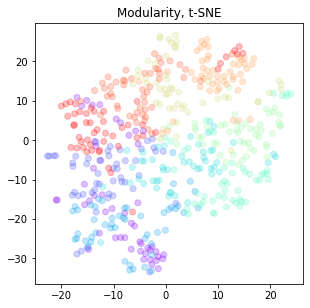

In [39]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Modularity, t-SNE')
ax.scatter(XMtsne[:,0], XMtsne[:,1], c=colours, alpha=0.25);

#### Spectral embedding of the normalised Laplacian matrix

In [12]:
D = np.diag(np.sum(A,axis=0))
L = np.linalg.inv(np.sqrt(D)).dot(A.dot(np.linalg.inv(np.sqrt(D))))

In [13]:
dL, UL = np.linalg.eig(L)
XL = UL[:,0:k].dot(np.diag(np.sqrt(np.abs(dL[0:k]))))

Use PCA to embed the Laplacian spectral embedding into two dimensions.

In [14]:
XLpca = pca.fit_transform(XL)

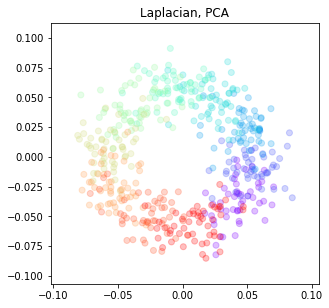

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Laplacian, PCA')
ax.scatter(XLpca[:,0], XLpca[:,1], c=colours, alpha=0.25);

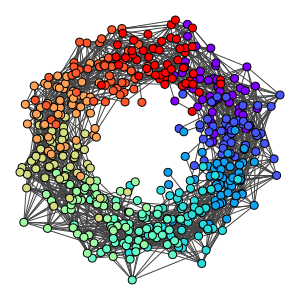

In [20]:
G.vs["pos"] = XLpca
visual_style["layout"] = G.vs["pos"]
ig.plot(G, **visual_style)

Use t-SNE to embed the Laplacian spectral embedding into two dimensions.

In [19]:
XLtsne = tsne.fit_transform(XL)

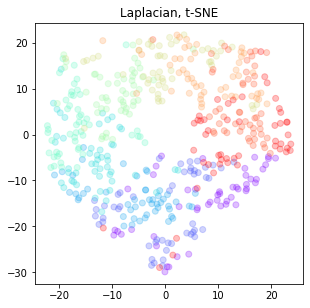

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Laplacian, t-SNE')
ax.scatter(XLtsne[:,0], XLtsne[:,1], c=colours, alpha=0.25);

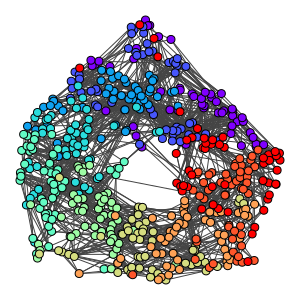

In [21]:
G.vs["pos"] = XLtsne
visual_style["layout"] = G.vs["pos"]
ig.plot(G, **visual_style)

#### Node2Vec embedding

Run node2vec with the default transition parameters, $p=1$, $q=1$. Note that this requires the graph in networkx format.

In [80]:
node2vec = Node2Vec(nx.Graph(G.get_edgelist()), dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities: 100%|██████████| 500/500 [00:00<00:00, 5811.52it/s]


In [81]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [82]:
NV = np.zeros((n,64))

for i in range(n):
    NV[i] = model.wv.get_vector(str(i))

Use PCA to visual the embedding in two dimensions.

In [83]:
NVpca = pca.fit_transform(NV)

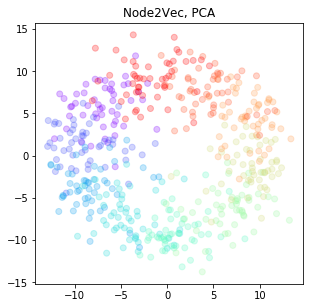

In [84]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Node2Vec, PCA')
ax.scatter(NVpca[:,0], NVpca[:,1], c=colours, alpha=0.25);

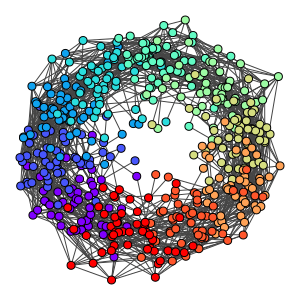

In [85]:
G.vs["pos"] = NVpca
visual_style["layout"] = G.vs["pos"]
ig.plot(G, **visual_style)

Use t-SNE to visual the embedding in two dimensions.

In [86]:
NVtsne = tsne.fit_transform(NV)

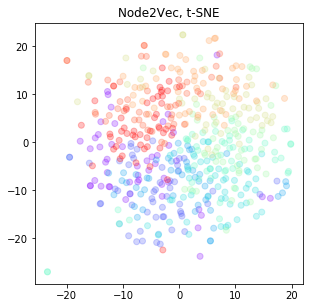

In [87]:
fig, ax = plt.subplots(1,1, figsize=(4.8,4.8))
ax.set_title('Node2Vec, t-SNE')
ax.scatter(NVtsne[:,0], NVtsne[:,1], color=colours, alpha=0.25);

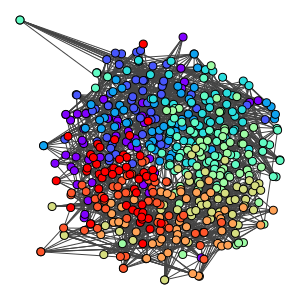

In [88]:
G.vs["pos"] = NVtsne
visual_style["layout"] = G.vs["pos"]
ig.plot(G, **visual_style)